In [8]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup as bs
import requests
import lxml

In [9]:
#запишем переменную soup, она будет содержать текст html кода страницы
url = 'https://www.labirint.ru/genres/3079/'
soup = bs(requests.get(url).text, 'lxml')
books = soup.find('div', class_='inner-catalog').findAll('div', class_= 'genres-carousel__item') 
#будет содержать в себе полное описание каждой книги



#name = book.find('a', class_= 'product-title-link').text.strip() -- получаем название из описания
#author = book.find('div', class_= 'product-author').text.strip() -- получаем имя автора
#new_price = book.find('div', class_= 'price').find('span', class_= 'price-val').text.strip() -- получаем новую цену
#old_price = book.find('div', class_= 'price').find('span', class_= 'price-old') -- получаем старую цену

In [10]:
#создаем список в который будем записывать атрибуты каждой книги
data = []
#запустим цикл с заданной переменной r, которая будет увеличиваться на 1 каждый раз 
#после завершения цикла, и будет означать номер страницы на сайте
for r in range(5):
    url = 'https://www.labirint.ru/genres/3079/'+'?page='+'r'
    soup = bs(requests.get(url).text, 'lxml')
    books = soup.find('div', class_='inner-catalog').findAll('div', class_= 'genres-carousel__item')
    for book in books:
        name = book.find('a', class_= 'product-title-link').text.strip()
        try:
            author = book.find('div', class_= 'product-author').text.strip()
        except:
            author = 'null'
        try:
            new_price = book.find('div', class_= 'price').find('span', class_= 'price-val').text.strip()
        except:
            new_price = 'null'
        try:
            old_price = book.find('div', class_= 'price').find('span', class_= 'price-old').text.strip()
        except:
            old_price = 'null'
        data.append([name, author, new_price, old_price])

In [11]:
#Создадим датафрейм
data = pd.DataFrame(data, columns = ['name', 'author', 'new_price', 'old_price'])

In [12]:
data

,name,author,new_price,old_price
0,Интеллектуальный анализ данных. Учебное пособие,Татарникова Татьяна Михайловна,952 ₽,1 730
1,Конструирование систем глубокого обучения. Рук...,"Ванг, Сзето",2 764 ₽,5 026
2,Машинное обучение в финансах. Учебник для маги...,"Богатырев, Помулев, Затевахина",1 183 ₽,2 151
3,Введение в анализ данных. Поиск структуры данн...,Криволапов Сергей Яковлевич,2 855 ₽,null
4,Практические работы по информатике и основам и...,"Галыгина, Галыгина",2 230 ₽,4 055
...,...,...,...,...
295,Математические алгоритмы для программистов. 3D...,Орланд Пол,4 455 ₽,null
296,Методы и средства научного исследования при ос...,"Мелехина, Поздеева",739 ₽,1 344
297,Анализ данных. Моделирование инвестиционного п...,"Цогоева, Волик, Цогоев",592 ₽,1 076
298,Основы искусственного интеллекта. Лабораторный...,"Галыгина, Галыгина",3 872 ₽,7 040


## Проверим гепотезу о равенстве средних новых и старых цен

In [13]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import kstest

In [14]:
data['new_price'] = data['new_price'].replace([' ','₽'], ['',''], regex = True)
data['old_price']  = data['old_price'].replace([' ','₽'], ['',''], regex = True)
data['old_price'] = data['old_price'].replace('null', 0)

In [15]:
data['new_price'], data['old_price'] = pd.to_numeric(data['new_price']), pd.to_numeric(data['old_price'])

In [16]:
data[data['old_price'] == 0] =  round(data['old_price'].median()) #пустые значения заполним медианой

(array([65., 60., 45., 45., 10., 15., 25., 25.,  0., 10.]),
 array([ 483. , 1138.7, 1794.4, 2450.1, 3105.8, 3761.5, 4417.2, 5072.9,
        5728.6, 6384.3, 7040. ]),
 <BarContainer object of 10 artists>)

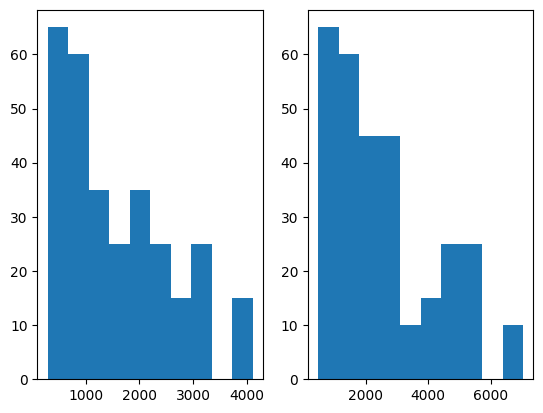

In [17]:
fig, (axs1, axs2) = plt.subplots(1,2) 
axs1.hist(data['new_price']) #распределение новых цен не похоже на нормальное
axs2.hist(data['old_price']) #распределение старых цен не похоже на нормальное

## Распределения цен сильно отличаются от нормального, поэтому будем использовать бутстрап

In [18]:
def getbootstrap(arr, N):
    n = arr.size
    boot = np.random.choice(arr, size = (n, N), replace = True)
    return boot

In [19]:
newp = getbootstrap(data['new_price'], 100000)
op = getbootstrap(data['old_price'], 100000)

In [20]:
newp_mean = np.mean(newp, axis = 0) 
op_mean = np.mean(op, axis = 0)

(array([3.000e+00, 1.000e+00, 5.000e+00, 7.000e+00, 2.300e+01, 2.200e+01,
        4.600e+01, 8.600e+01, 1.260e+02, 2.000e+02, 3.350e+02, 5.060e+02,
        7.700e+02, 1.013e+03, 1.429e+03, 1.986e+03, 2.398e+03, 3.050e+03,
        3.768e+03, 4.627e+03, 5.116e+03, 5.524e+03, 6.170e+03, 6.467e+03,
        6.750e+03, 6.501e+03, 6.347e+03, 6.111e+03, 5.531e+03, 4.908e+03,
        4.360e+03, 3.731e+03, 2.995e+03, 2.421e+03, 1.859e+03, 1.406e+03,
        1.084e+03, 7.410e+02, 5.400e+02, 3.710e+02, 2.400e+02, 1.660e+02,
        9.300e+01, 5.800e+01, 5.600e+01, 1.800e+01, 1.700e+01, 8.000e+00,
        4.000e+00, 6.000e+00]),
 array([2205.96      , 2222.28253333, 2238.60506667, 2254.9276    ,
        2271.25013333, 2287.57266667, 2303.8952    , 2320.21773333,
        2336.54026667, 2352.8628    , 2369.18533333, 2385.50786667,
        2401.8304    , 2418.15293333, 2434.47546667, 2450.798     ,
        2467.12053333, 2483.44306667, 2499.7656    , 2516.08813333,
        2532.41066667, 2548.7332    

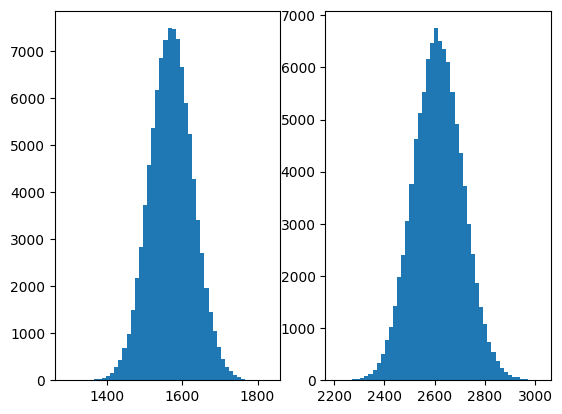

In [21]:
fig, (axs1, axs2) = plt.subplots(1,2)
axs1.hist(newp_mean, bins=50)
axs2.hist(op_mean, bins=50) 

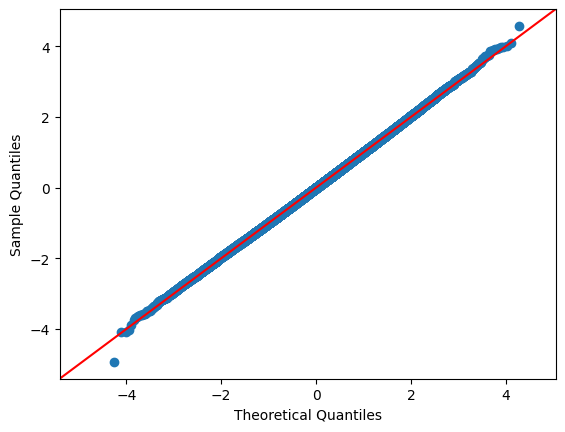

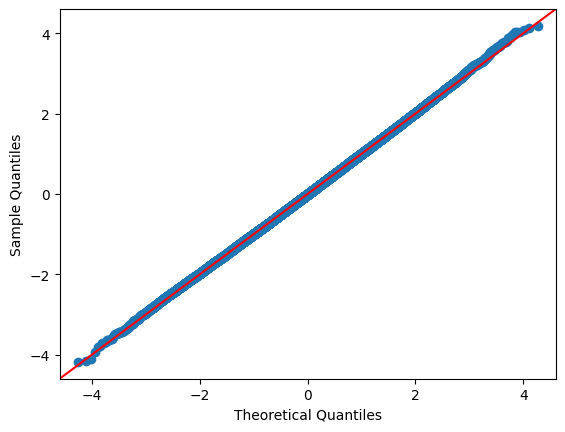

In [23]:
op_scale = (op_mean - op_mean.mean())/op_mean.std()
newp_scale = (newp_mean - newp_mean.mean())/newp_mean.std()
axs1 = sm.qqplot(newp_scale,line = '45')
axs2 = sm.qqplot(op_scale, line = '45') #на графиках также нормальное распределение

In [24]:
kstest(op_scale, 'norm'), kstest(newp_scale, 'norm')
#тест показывает что распределение средних сильно близко к нормальному

(KstestResult(statistic=0.004173648669731966, pvalue=0.06120427071923751, statistic_location=-0.04946001365072909, statistic_sign=1),
 KstestResult(statistic=0.003880290248480134, pvalue=0.09818597336642731, statistic_location=-0.2650909232201538, statistic_sign=1))

In [25]:
sm.stats.ttest_ind(newp_mean, op_mean) # т-тест показал, что средние выборок различаются со значимостью почти 100%

(-2912.6907775681716, 0.0, 199998.0)